In [1]:
"""
Baseline for CIL project on road segmentation.
This simple baseline consits of a CNN with two convolutional+pooling layers with a soft-max loss
"""

import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image
from random import shuffle
import random

import code

import tensorflow.python.platform

import numpy as np
import tensorflow as tf

import cil_helper as cil

from skimage.feature import greycomatrix, greycoprops

In [2]:
try:
    tf.app.flags.DEFINE_string('log_dir', '/tmp/tensorflow_lukas',
                           """Directory where to write event logs """
                           """and checkpoint.""")
except: 
    print(tf.app.flags.FLAGS.log_dir)
    
FLAGS = tf.app.flags.FLAGS

In [3]:
TRAINING_SIZE = 50
VALIDATION_SIZE = 5  # Size of the validation set.
TEST_SIZE = 20
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64 # 64
NUM_EPOCHS = 200
RESTORE_MODEL = False # If True, restore existing model instead of training a new one
RECORDING_STEP = 10

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!

PATCH_SIZE = 16
EXTRA_CONTEXT = 16
CONTEXT_SIZE = EXTRA_CONTEXT + PATCH_SIZE + EXTRA_CONTEXT

In [4]:
random.seed(SEED)

In [5]:
data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 
test_dir = "test/"

In [6]:
# returns all train images in rgb
def get_train_imgs():
    imgs = []
    for i in range(TRAINING_SIZE):
        imageid = "satImage_%.3d" % (i+1)
        image_filename = train_data_filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            raise Exception('File ' + image_filename + ' does not exist')
    return np.asarray(imgs)

# returns all test images as rgb
def get_test_imgs():
    imgs = []
    for i in range(TEST_SIZE):
        imagename = "test_" + str(i+1)
        image_filename = test_dir + imagename + "/" + imagename + ".png"
        if os.path.isfile(image_filename):
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            raise Exception('File ' + image_filename + ' does not exist')
    return np.asarray(imgs)

# Get prediction overlaid on the original image for given input image
def get_prediction_with_overlay(img):
    
    img_prediction = get_prediction(img)
    oimg = cil.make_img_overlay(img[:,:,:3], img_prediction)

    return oimg

# Get a concatenation of the prediction and groundtruth for given input file
def get_prediction_with_groundtruth(img):
    
    img_prediction = get_prediction(img)
    cimg = cil.concatenate_images(img[:,:,:3], img_prediction)

    return cimg

# Get prediction for given input image 
def get_prediction(img):
    data = np.asarray(cil.img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    data_node = tf.constant(data)
    output = tf.nn.softmax(model(data_node))
    output_prediction = s.run(output)
    img_prediction = cil.label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

# returns a numpy array [Saturation, Lightness] of a pixel
def sat_light(rgb):
    Cmax = rgb.max()
    Cmin = rgb.min()
    d = Cmax - Cmin
    L = (Cmax + Cmin) / 2
    S = d / (1 - (abs(2 * L - 1)))
    if np.isnan(S):
        S = 0
    return np.asarray([S, L], dtype=np.float32)

#returns edges
def texture_features(image):
    result = np.empty(list(image.shape) + [2])
    h = image.shape[0]
    w = image.shape[1]
    result[:,:,0] = np.vstack((image[:-1,:] - image[1:,:], np.zeros((1,w))))
    result[:,:,1] = np.hstack((image[:,:-1] - image[:,1:], np.zeros((h,1))))
    return np.max(np.abs(result),axis=2)

NUM_CHANNELS = 6 # RGB, Saturation, Lightness, Edges
def preprocess(img):
    new_shape = list(img.shape)
    new_shape[2] = NUM_CHANNELS
    result = np.empty(new_shape, dtype=np.float32)
    result[:,:,:3] = img
    for y in range(len(img)):
        for x in range(len(img[y])):
            result[y,x,3:5] = sat_light(result[y,x,:3])
    #print('Saturation and lightness computed.')
    result[:,:,5] = texture_features(result[:,:,4])
    #print('Texture deatures computed.')
    return result

# takes an array of images, preprocesses them and stores the result
# in save_dir/preprocessed.npy
def preprocess_imgs(imgs, save_dir):
    assert save_dir.endswith('/')
    processed = []
    for i in range(len(imgs)):
        processed.append(preprocess(imgs[i]))
        print('Image ' + str(i) + ' preprocessed.')
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    processed_np = np.asarray(processed)
    np.save(save_dir + 'preprocessed2.npy', processed_np)
    return processed_np

def load_preproc(save_dir):
    assert save_dir.endswith('/')
    return np.load(save_dir + 'preprocessed2.npy')

def load_labels():
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, TRAINING_SIZE+1):
        imageid = "satImage_%.3d" % i
        image_filename = train_labels_filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    labels = np.asarray(gt_imgs, dtype=np.float32)
    return labels

def store_channel_to_img(chan):
    img = (chan * 255).astype('uint8')
    png = Image.fromarray(img)
    png.show
    return png

def show(chan):
    chan = chan + chan.min()
    chan = chan / chan.max()
    img = (chan * 255).astype('uint8')
    png = Image.fromarray(img)
    png.show
    return png

In [7]:
PREPROCESS_TRAIN_DATA = False
PREPROCESS_TEST_DATA = False

if PREPROCESS_TRAIN_DATA:
    preprocess_imgs(get_train_imgs(), train_data_filename)
if PREPROCESS_TEST_DATA:
    preprocess_imgs(get_test_imgs(), test_dir)

In [8]:
train_data = load_preproc(train_data_filename)
train_labels = load_labels()
print(train_data.shape)
print(train_labels.shape)

(100, 400, 400, 6)
(50, 400, 400)


In [9]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, CONTEXT_SIZE, CONTEXT_SIZE, NUM_CHANNELS),
    name='train_data')
train_labels_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, cil.NUM_LABELS),
    name='train_labels')

In [10]:
FILTER1_SIZE = 5
FILTER1_COUNT = 32
FILTER1_STRIDES = [1,1,1,1]

POOL1_FACTOR = 2

FILTER2_SIZE = 5
FILTER2_COUNT = 64
FILTER2_STRIDES = [1,1,1,1]

POOL2_FACTOR = 2

FILTER3_SIZE = 3
FILTER3_COUNT = 64
FILTER3_STRIDES = [1,1,1,1]

POOL3_FACTOR = 1

FC1_SIZE = 512
FC2_SIZE = 128

In [11]:
filter1_shape = [FILTER1_SIZE, FILTER1_SIZE, NUM_CHANNELS, FILTER1_COUNT]
filter1 = tf.Variable(tf.truncated_normal(filter1_shape, stddev=.1, seed=SEED))
conv1_biases = tf.Variable(tf.zeros(shape=[FILTER1_COUNT]))

filter2_shape = [FILTER2_SIZE, FILTER2_SIZE, FILTER1_COUNT, FILTER2_COUNT]
filter2 = tf.Variable(tf.truncated_normal(filter2_shape, stddev=.1, seed=SEED))
conv2_biases = tf.Variable(tf.constant(.1, shape=[FILTER2_COUNT]))

filter3_shape = [FILTER3_SIZE, FILTER3_SIZE, FILTER2_COUNT, FILTER3_COUNT]
filter3 = tf.Variable(tf.truncated_normal(filter3_shape, stddev=.1, seed=SEED))
conv3_biases = tf.Variable(tf.constant(.1, shape=[FILTER3_COUNT]))

side = (((CONTEXT_SIZE // POOL1_FACTOR) // POOL2_FACTOR) // POOL3_FACTOR)
reshape_depth = side * side * FILTER3_COUNT
fc1_weights = tf.Variable(
    tf.truncated_normal([reshape_depth, FC1_SIZE], stddev=.1, seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[FC1_SIZE]))

fc2_weights = tf.Variable(
    tf.truncated_normal([FC1_SIZE, FC2_SIZE], stddev=.1, seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[FC2_SIZE]))

fc_last_weights = tf.Variable(
    tf.truncated_normal([FC2_SIZE, cil.NUM_LABELS], stddev=.1, seed=SEED))
fc_last_biases = tf.Variable(tf.constant(0.1, shape=[cil.NUM_LABELS]))

In [12]:
def model(input_node, dropout=False):
    print(input_node.get_shape())

    conv1 = tf.nn.conv2d(input_node, filter1, FILTER1_STRIDES, 
                         padding='SAME', name='conv1')

    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

    pool1 = tf.nn.max_pool(relu1, ksize=[1,POOL1_FACTOR,POOL1_FACTOR,1], 
                           strides=[1,POOL1_FACTOR,POOL1_FACTOR,1], padding='SAME')
    print(pool1.get_shape())
    ######################
    conv2 = tf.nn.conv2d(pool1, filter2, FILTER2_STRIDES, 
                         padding='SAME', name='conv2')

    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))

    pool2 = tf.nn.max_pool(relu2, ksize=[1,POOL2_FACTOR,POOL2_FACTOR,1], 
                           strides=[1,POOL2_FACTOR,POOL2_FACTOR,1], padding='SAME')
    print(pool2.get_shape())
    ######################
    conv3 = tf.nn.conv2d(pool2, filter3, FILTER3_STRIDES, 
                         padding='SAME', name='conv2')

    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))

    pool3 = tf.nn.max_pool(relu3, ksize=[1,POOL3_FACTOR,POOL3_FACTOR,1], 
                           strides=[1,POOL3_FACTOR,POOL3_FACTOR,1], padding='SAME')
    print(pool3.get_shape())
    ######################
    shp = pool3.get_shape().as_list()
    reshape = tf.reshape(pool3, [shp[0], shp[1] * shp[2] * shp[3]])
    print(reshape.get_shape())

    fc1 = tf.nn.sigmoid(tf.matmul(reshape, fc1_weights) + fc1_biases)
    if (dropout):
        fc1 = tf.nn.dropout(fc1, .5, seed=SEED)
    print(fc1.get_shape())

    fc2 = tf.nn.sigmoid(tf.matmul(fc1, fc2_weights) + fc2_biases)
    if (dropout):
        fc2 = tf.nn.dropout(fc2, .5, seed=SEED)
    print(fc2.get_shape())

    fc_last = tf.matmul(fc2, fc_last_weights) + fc_last_biases
    print(fc_last.get_shape())
    return fc_last

In [13]:
logits = model(train_data_node, dropout=True)

(64, 48, 48, 6)
(64, 24, 24, 32)
(64, 12, 12, 64)
(64, 12, 12, 64)
(64, 9216)
(64, 512)
(64, 128)
(64, 2)


In [14]:
output = tf.nn.softmax(logits)

In [15]:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, train_labels_node))
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases) +
                tf.nn.l2_loss(fc_last_weights) + tf.nn.l2_loss(fc_last_biases))
loss += 5e-4 * regularizers

In [16]:
DECAY_STEP = 5000
batch_idx = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                # Base learning rate.
    batch_idx * BATCH_SIZE,  # Current index into the dataset.
    DECAY_STEP,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

In [17]:
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
#    loss, global_step=batch_idx)
optimizer = tf.train.MomentumOptimizer(learning_rate, 0.0).minimize(
    loss, global_step=batch_idx)

In [18]:
def get_window(image, y, x, truth=None):
    #padding the image with wrap-around
    window = np.take(np.take(image, 
                     range(y,y+CONTEXT_SIZE), axis=0,mode='wrap'), 
                     range(x,x+CONTEXT_SIZE), axis=1,mode='wrap')
    if not truth is None:
        truth_window = np.take(np.take(truth,
     range(y+EXTRA_CONTEXT,y+EXTRA_CONTEXT+PATCH_SIZE), axis=0,mode='wrap'),
     range(x+EXTRA_CONTEXT,x+EXTRA_CONTEXT+PATCH_SIZE), axis=1,mode='wrap')
        return (window, truth_window)
    else:
        return window

def get_training_samples(batch_size):
    batch = np.empty((batch_size, CONTEXT_SIZE, CONTEXT_SIZE, NUM_CHANNELS))
    labels = np.empty((batch_size, cil.NUM_LABELS))
    for i in range(batch_size):
        pic_idx = random.randrange(0,TRAINING_SIZE)
        pic = train_data[pic_idx]
        y = random.randrange(0,pic.shape[0])
        x = random.randrange(0,pic.shape[1])
        
        window, truth = get_window(pic, y, x, train_labels[pic_idx])
        label = int(truth.mean() > .25)
        batch[i] = window
        labels[i][0] = label
        labels[i][1] = 1 - label
    return (batch, labels)

In [19]:
s = tf.Session()

In [20]:
s.run(tf.initialize_all_variables())
print ('Initialized!')

Initialized!


In [21]:
for epoch in range(NUM_EPOCHS):
    for i in range(RECORDING_STEP):
        batch, labels = get_training_samples(BATCH_SIZE)

        feed_dict = { train_data_node: batch
                    , train_labels_node: labels}
        
        s.run(optimizer, feed_dict=feed_dict)

    batch, labels = get_training_samples(BATCH_SIZE)
    feed_dict = { train_data_node: batch
                , train_labels_node: labels}
    l, pred = s.run([loss, output], feed_dict=feed_dict)
    error_rate = cil.error_rate(pred,labels)
    print('Epoch ' + str(epoch) + ':')
    print('Loss: ' + str(l))
    print('Error: ' + str(error_rate))

Epoch 0:
Loss: 9.85099
Error: 25.0
Epoch 1:
Loss: 9.83331
Error: 26.5625
Epoch 2:
Loss: 9.97312
Error: 35.9375
Epoch 3:
Loss: 9.77931
Error: 23.4375
Epoch 4:
Loss: 9.91388
Error: 35.9375
Epoch 5:
Loss: 9.70539
Error: 14.0625
Epoch 6:
Loss: 9.75049
Error: 17.1875
Epoch 7:
Loss: 9.78564
Error: 20.3125
Epoch 8:
Loss: 9.88216
Error: 35.9375
Epoch 9:
Loss: 9.84906
Error: 23.4375
Epoch 10:
Loss: 9.99462
Error: 35.9375
Epoch 11:
Loss: 9.8708
Error: 25.0
Epoch 12:
Loss: 9.92734
Error: 29.6875
Epoch 13:
Loss: 9.7297
Error: 15.625
Epoch 14:
Loss: 9.72763
Error: 20.3125
Epoch 15:
Loss: 9.93397
Error: 34.375
Epoch 16:
Loss: 9.83087
Error: 28.125
Epoch 17:
Loss: 9.77348
Error: 20.3125
Epoch 18:
Loss: 9.78207
Error: 23.4375
Epoch 19:
Loss: 9.89203
Error: 37.5
Epoch 20:
Loss: 9.76946
Error: 26.5625
Epoch 21:
Loss: 9.7726
Error: 29.6875
Epoch 22:
Loss: 9.95996
Error: 32.8125
Epoch 23:
Loss: 9.7597
Error: 21.875
Epoch 24:
Loss: 9.84128
Error: 31.25
Epoch 25:
Loss: 9.7333
Error: 21.875
Epoch 26:
Loss: 9

In [22]:
pred

array([[ 0.16011849,  0.83988148],
       [ 0.25092113,  0.74907893],
       [ 0.31138092,  0.68861914],
       [ 0.18172739,  0.81827259],
       [ 0.17090526,  0.82909471],
       [ 0.18933599,  0.81066394],
       [ 0.12496678,  0.87503326],
       [ 0.28543702,  0.71456301],
       [ 0.30342916,  0.69657087],
       [ 0.21597187,  0.78402805],
       [ 0.2062474 ,  0.79375261],
       [ 0.16312912,  0.83687091],
       [ 0.26063368,  0.73936635],
       [ 0.28800842,  0.71199161],
       [ 0.17584823,  0.82415175],
       [ 0.25218162,  0.74781841],
       [ 0.19763324,  0.80236673],
       [ 0.32440129,  0.67559874],
       [ 0.19218387,  0.80781609],
       [ 0.20473263,  0.79526734],
       [ 0.28218603,  0.71781397],
       [ 0.28250721,  0.71749276],
       [ 0.21245016,  0.78754985],
       [ 0.23202856,  0.76797146],
       [ 0.31768733,  0.68231267],
       [ 0.30259198,  0.69740802],
       [ 0.22021489,  0.77978516],
       [ 0.18295817,  0.81704187],
       [ 0.28748864,

In [23]:
pred_input = tf.placeholder(
    tf.float32,
    shape=(1, CONTEXT_SIZE, CONTEXT_SIZE, NUM_CHANNELS),
    name='pred_input')
pred_output = tf.nn.softmax(model(pred_input))

(1, 48, 48, 6)
(1, 24, 24, 32)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 512)
(1, 128)
(1, 2)


In [24]:
imgs = train_data[:1]
# assuming images are quadratic
num_patches = imgs[0].shape[0] // PATCH_SIZE
truth = np.empty((len(imgs), num_patches, num_patches, cil.NUM_LABELS))
preds = np.empty((len(imgs), num_patches, num_patches, cil.NUM_LABELS))
for img_idx in range(len(imgs)):
    img = imgs[img_idx]
    for patch_y in range(num_patches):
        y = patch_y * PATCH_SIZE - EXTRA_CONTEXT
        for patch_x in range(num_patches):
            x = patch_x * PATCH_SIZE - EXTRA_CONTEXT
            window, window_truth = get_window(img, y, x, train_labels[img_idx])
            pred = s.run(pred_output, {pred_input: [window]})
            preds[img_idx, patch_y, patch_x] = pred
            label = window_truth.mean()
            truth[img_idx, patch_y, patch_x, 0] = label
            truth[img_idx, patch_y, patch_x, 1] = 1 - label
    print('Done with image ' + str(img_idx))
truth = truth.reshape((len(imgs) * num_patches * num_patches, cil.NUM_LABELS))
preds = preds.reshape((len(imgs) * num_patches * num_patches, cil.NUM_LABELS))
error_rate = cil.error_rate(preds, truth)
print(error_rate)

Done with image 0
19.52


In [25]:
preds

array([[ 0.22945783,  0.77054214],
       [ 0.23343855,  0.76656151],
       [ 0.23387842,  0.76612163],
       ..., 
       [ 0.30433786,  0.69566208],
       [ 0.26381034,  0.73618966],
       [ 0.23759136,  0.76240861]])

In [26]:
preds_m = np.empty(preds.shape)

In [27]:
preds_m[:,0] = preds[:,0]+.3
preds_m[:,1] = 1 - preds_m[:,0]
cil.error_rate(preds_m, truth)

77.599999999999994

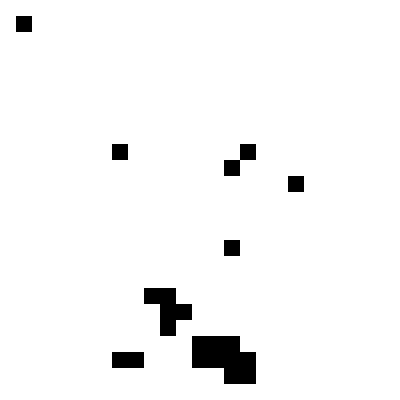

In [28]:
label_img = cil.label_to_img(imgs[0].shape[0],imgs[0].shape[1],
                             PATCH_SIZE,PATCH_SIZE,preds_m)
show(label_img)

In [29]:
print ("Running prediction on training set")
prediction_training_dir = "predictions_training/"
if not os.path.isdir(prediction_training_dir):
    os.mkdir(prediction_training_dir)
    
for i in range(TRAINING_SIZE):
    pimg = get_prediction_with_groundtruth(train_preproc[i])
    Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i+1) + ".png")
    oimg = get_prediction_with_overlay(train_preproc[i])
    oimg.save(prediction_training_dir + "overlay-8x8_" + str(i+1) + ".png")  

Running prediction on training set


NameError: name 'train_preproc' is not defined

In [ ]:
print ("Running prediction on test set")
prediction_test_dir = "predictions_test/"
if not os.path.isdir(prediction_test_dir):
    os.mkdir(prediction_test_dir)

test_preproc = load_preproc(test_dir)
for i in range(TEST_SIZE):
    pred = get_prediction(test_preproc[i])
    pimg = cil.img_float_to_uint8(pred)
    Image.fromarray(pimg).save(prediction_test_dir + "prediction_" + str(i+1) + ".png")
    oimg = cil.make_img_overlay(test_preproc[i], pred)
    oimg.save(prediction_test_dir + "overlay-8x8_" + str(i+1) + ".png")

In [ ]:
import re
th = 0.75

In [ ]:
# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > th:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


def save(submission_filename):
    #subm#ission_filename = 'submission_07.csv'
    image_filenames = []
    for i in range(1, 51):
        imagename = 'prediction_' + str(i)
        image_filename = 'predictions_test/' + imagename + '.png'
        print(image_filename)
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename, *image_filenames)
    
save('submission_lukas_11_2.5.csv')